In [61]:
import sys
sys.path.append("..")
import cv2, requests
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

In [62]:
img = cv2.imread("../data/data_img/path01.PNG")

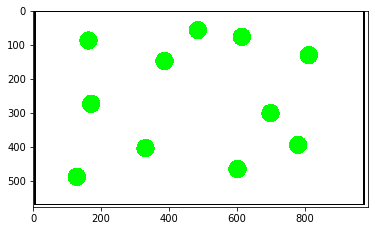

In [63]:
plt.imshow(img)

In [64]:
green_bound = [[0, 200, 0], [20, 255, 20]]
lower = np.array(green_bound[0], dtype = "uint8")
upper = np.array(green_bound[1], dtype = "uint8")


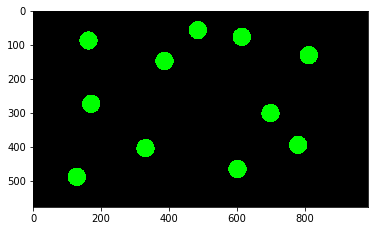

In [65]:
mask = cv2.inRange(img, lower, upper)
masked_img = cv2.bitwise_and(img, img, mask = mask)
plt.imshow(masked_img)

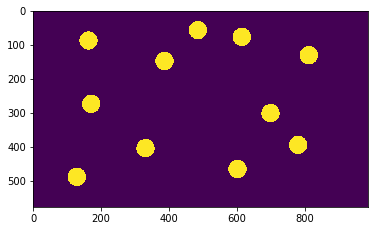

In [66]:
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)
plt.imshow(masked_img)

In [67]:
contours, hierarchy = cv2.findContours(masked_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [68]:
positions = []
for c in contours:
    if cv2.contourArea(c) <= 50 :
        continue    
    x,y,w,h = cv2.boundingRect(c)
    positions.append((x,y,w,h))
    cv2.rectangle(img, (x, y), (x + w, y + h), (255,0,0), 2)
    cv2.circle(img, (int(x+w/2), int(y+h/2)), 1, (0,0,255), 2) 
    center = (x,y)

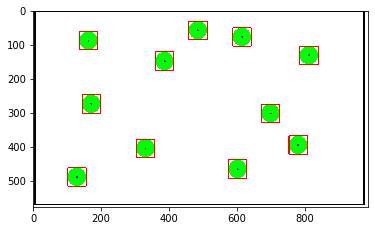

In [69]:
plt.imshow(img)

In [70]:
positions

[(102, 461, 54, 54),
 (575, 438, 54, 54),
 (304, 377, 54, 54),
 (753, 367, 54, 54),
 (672, 274, 54, 54),
 (144, 246, 54, 54),
 (360, 120, 54, 54),
 (785, 103, 54, 54),
 (136, 60, 54, 54),
 (588, 49, 54, 54),
 (458, 29, 54, 54)]

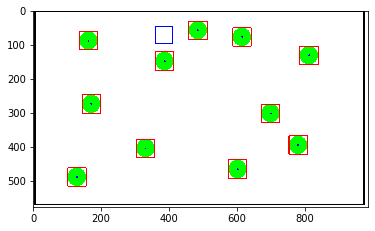

In [154]:
im2 = img.copy()
sp = (360, 45, sq_width, sq_width)
sq_width = 50
cv2.rectangle(im2, (sp[0],sp[1]), (sp[0]+sp[2], sp[1]+sp[3]), (0,0,255), 2)
plt.imshow(im2)

In [202]:
def check_collision(rects, rect2):
    for rect1 in rects:
        if(rect1[0] < rect2[0] + rect2[2] and rect1[0] + rect1[2] > rect2[0] 
            and rect1[1] < rect2[1] + rect2[3] and rect1[1] + rect1[3] > rect2[1]):
            return True
    return False

def get_open_tile(positions, rect):
    tiles = {
        "right": (rect[0] + sq_width, rect[1], rect[2], rect[3]),
        "left":(rect[0] - sq_width, rect[1], rect[2], rect[3]),
        "down": (rect[0], rect[1]+sq_width, rect[2], rect[3]),
        "up":(rect[0], rect[1]-sq_width, rect[2], rect[3])
    }
    for d,p in tiles.items():
        if not check_collision(positions, p):
            return p
        else:
            print("Cannot move " + d)
            
def get_longest_path(positions, rect, limits={"xMin": 0, "xMax": 1000, "yMin": 0, "yMax": 520}):    
    tiles = [
        {"key": "right", "pos": [rect[0] + sq_width, rect[1], rect[2], rect[3]], "posIdx": 0, "count": 0, "inc": sq_width},
        {"key": "left", "pos": [rect[0] - sq_width, rect[1], rect[2], rect[3]], "posIdx":0, "count": 0, "inc": -sq_width},
        {"key": "down", "pos": [rect[0], rect[1]+sq_width, rect[2], rect[3]], "posIdx": 1, "count": 0, "inc": sq_width},
        {"key": "up", "pos": [rect[0], rect[1]-sq_width, rect[2], rect[3]], "posIdx": 1, "count": 0, "inc": -sq_width}  
    ]
    
    
    for tile in tiles:
        limit = 10   
        tile_open = not check_collision(positions, tile["pos"])
        while tile_open and limit > 0:            
            pos = tile["pos"][:]
            pos[tile["posIdx"]] += tile["inc"]
            
            if pos[0] < limits["xMax"] and pos[0] > limits["xMin"] and pos[1] < limits["yMax"] and pos[1] > limits["yMin"]:            
                tile_open = not check_collision(positions, pos)
            else:
                tile_open = False
            
            if tile_open:
                tile["count"] += 1
                tile["pos"] = pos
            
            limit -= 1
            
    tiles = sorted(tiles, key=lambda x: x["count"])
    print(tiles)
    return tiles[-1]["pos"]
    
    

def draw_rect(img, rect):
    img = cv2.rectangle(img, (rect[0],rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (255,150,0), 2)
    return img

[{'key': 'right', 'pos': [410, 45, 50, 50], 'posIdx': 0, 'count': 0, 'inc': 50}, {'key': 'down', 'pos': [360, 95, 50, 50], 'posIdx': 1, 'count': 0, 'inc': 50}, {'key': 'up', 'pos': [360, -5, 50, 50], 'posIdx': 1, 'count': 0, 'inc': -50}, {'key': 'left', 'pos': [210, 45, 50, 50], 'posIdx': 0, 'count': 2, 'inc': -50}]


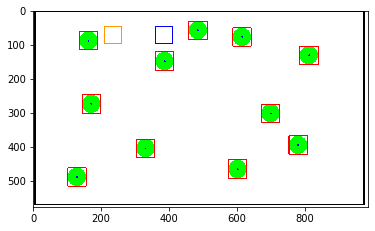

In [212]:
im_move = im2.copy()
pos = get_longest_path(positions, sp)
im_move = draw_rect(im_move, pos)
plt.imshow(im_move)

[{'key': 'left', 'pos': [160, 45, 50, 50], 'posIdx': 0, 'count': 0, 'inc': -50}, {'key': 'up', 'pos': [210, -5, 50, 50], 'posIdx': 1, 'count': 0, 'inc': -50}, {'key': 'right', 'pos': [360, 45, 50, 50], 'posIdx': 0, 'count': 2, 'inc': 50}, {'key': 'down', 'pos': [210, 495, 50, 50], 'posIdx': 1, 'count': 8, 'inc': 50}]


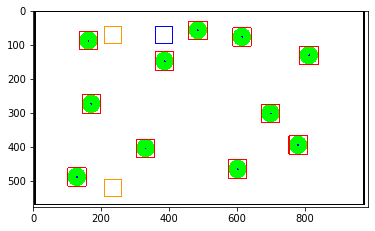

In [213]:
pos = get_longest_path(positions, pos)
im_move = draw_rect(im_move, pos)
plt.imshow(im_move)

[{'key': 'left', 'pos': [160, 495, 50, 50], 'posIdx': 0, 'count': 0, 'inc': -50}, {'key': 'down', 'pos': [210, 545, 50, 50], 'posIdx': 1, 'count': 0, 'inc': 50}, {'key': 'up', 'pos': [210, 45, 50, 50], 'posIdx': 1, 'count': 8, 'inc': -50}, {'key': 'right', 'pos': [760, 495, 50, 50], 'posIdx': 0, 'count': 10, 'inc': 50}]


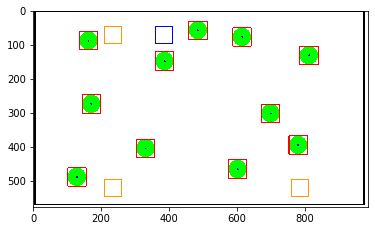

In [214]:
pos = get_longest_path(positions, pos)
im_move = draw_rect(im_move, pos)
plt.imshow(im_move)

[{'key': 'down', 'pos': [760, 545, 50, 50], 'posIdx': 1, 'count': 0, 'inc': 50}, {'key': 'up', 'pos': [760, 445, 50, 50], 'posIdx': 1, 'count': 0, 'inc': -50}, {'key': 'right', 'pos': [960, 495, 50, 50], 'posIdx': 0, 'count': 3, 'inc': 50}, {'key': 'left', 'pos': [210, 495, 50, 50], 'posIdx': 0, 'count': 10, 'inc': -50}]


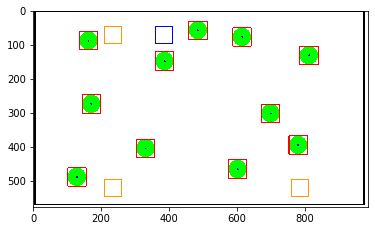

In [215]:
pos = get_longest_path(positions, pos)
im_move = draw_rect(im_move, pos)
plt.imshow(im_move)

[{'key': 'left', 'pos': [160, 495, 50, 50], 'posIdx': 0, 'count': 0, 'inc': -50}, {'key': 'down', 'pos': [210, 545, 50, 50], 'posIdx': 1, 'count': 0, 'inc': 50}, {'key': 'up', 'pos': [210, 45, 50, 50], 'posIdx': 1, 'count': 8, 'inc': -50}, {'key': 'right', 'pos': [760, 495, 50, 50], 'posIdx': 0, 'count': 10, 'inc': 50}]


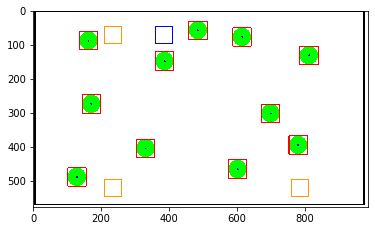

In [216]:
pos = get_longest_path(positions, pos)
im_move = draw_rect(im_move, pos)
plt.imshow(im_move)